# Interval calculations from Variables Data

Based on Castrup "Calibration Intervals from Variables Data", 2005 NCSLI Workshop & Symposium, Washington D.C, and "Establishment and Adjustment of Calibration Intervals", NASA Measurement Quality Assurance Handbook - Annex 5 (2010). NASA-HDBK-8739.19-5.

The `VariablesInterval` class implements both methods described in Castrup's paper: the Reliability Target method and the Uncertainty Target method. Both methods operate on data in the format of deviation-from-prior-calibration versus time-since-last-calibration.

Depending on the format of the input data, there two options for setting up the calculation:

1. Use `VariablesIntervalAssets` if the data is in as-found and as-left measurement format
2. Use `VariablesInterval` if the data is already in time-since-last, deviation-from-prior format

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser

from suncal.intervals import VariablesInterval, VariablesIntervalAssets

## Data in As-found and As-left format

If the data is given in as-found and as-left measurement values, use the `VariablesInterval.from_timedata()` function to initialize the calculation.

If as-found equals as-left (i.e. no adjustments were made during any calibration), setting `use_all_deltas=True` will extract non-consecutive intervals from the as-found data, for example by including the interval between the first and third calibrations.

Here, we make up some random data, equally spaced in time. With all the actual intervals the same length, it is impossible to fit a curve to $\Delta y$ vs $\Delta t$. However, because no adjustments were made (yfound == yleft), `use_alldeltas` was set to extract other interval lengths and provide values that can be fit.

In [2]:
m = -.005  # Slope
s = .05    # Scatter
day = np.linspace(20, 40, num=10)   # Actual date of calibration. from_timedata converts this to deltas.
np.random.seed(342342)
yfound = np.random.normal(day*m, s)

#v = VariablesInterval.from_timedata(day, yfound, use_all_deltas=True, u0=.05)
v = VariablesIntervalAssets(u0=0.05, use_alldeltas=True, utarget=0.1, rlimits=(-0.5, 0.5), rconf=0.9)
v.updateasset('asset123', enddates=day, asfound=yfound)
v.calculate()  # Runs both methods

Method              | Interval  
-------------------|----------
Uncertainty Target  | 51.93     
Reliability Target  | 45.69     


![IMG0][]

![IMG1][]



[IMG0]: 
[IMG1]: 

### Other calculator outputs

The results of the interval calculation are stored in the `.out` parameter of the `VariablesInterval` object.

In [3]:
v.out.fit   # Parameters of the fit line, displayed in table

### Fit line


Parameter   | Value       
-----------|------------
a           | -7.3928e-03

In [4]:
print(v.out.fit.b)     # Fit parameters as an array (length 1 for a line fit)
print(v.out.fit.cov)   # Covariance of fit parameters (1x1 for m=1 line fit)

[-0.00739283]
[[1.10768126e-06]]


In [5]:
v.out.fit.predict_deviation(15)   # Get the predicted deviation and expanded uncertainty at any time delta

(-0.11089237818086069, 0.17174436682203237)

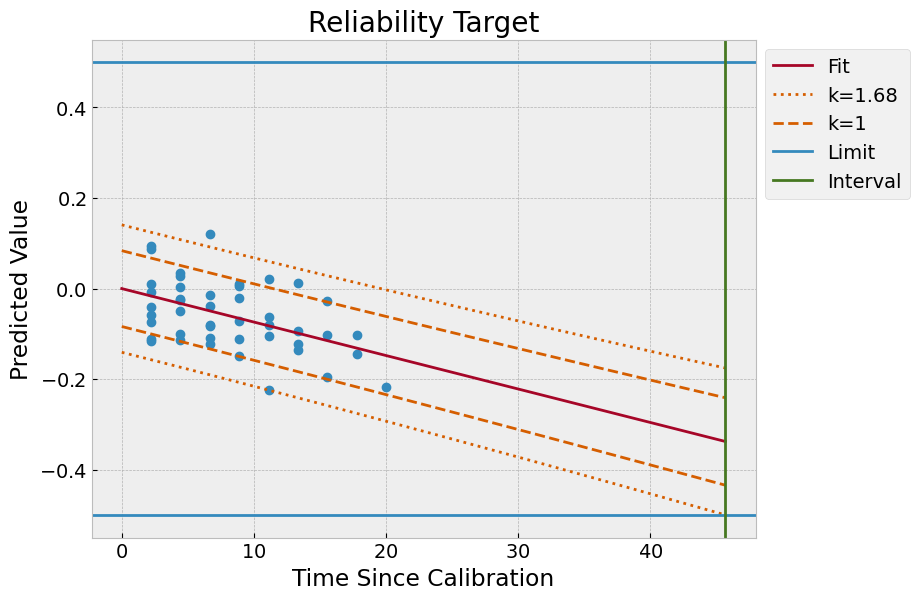

In [6]:
v.out.reliability.plot();   # Plot the results

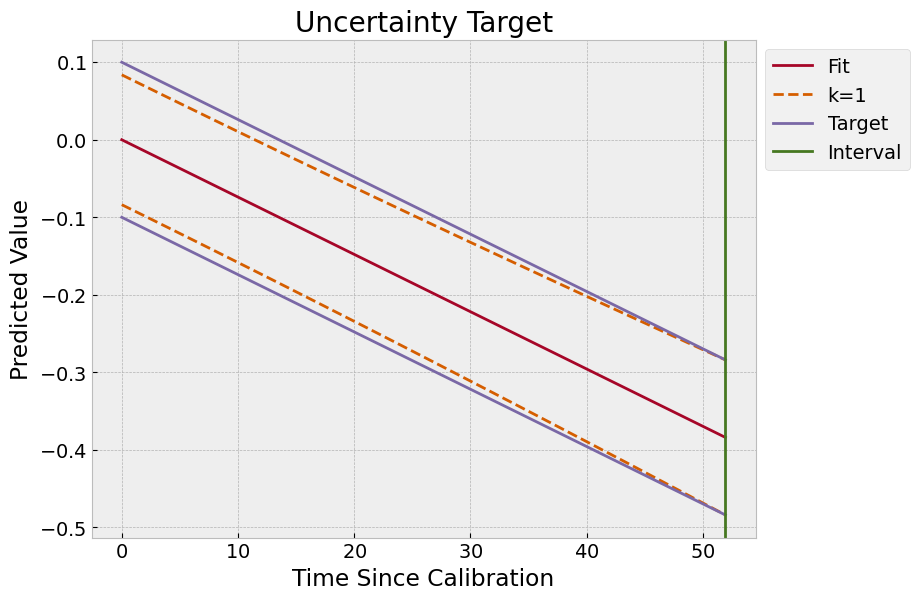

In [7]:
v.out.uncertainty.plot();  # Plot the reliability method interval

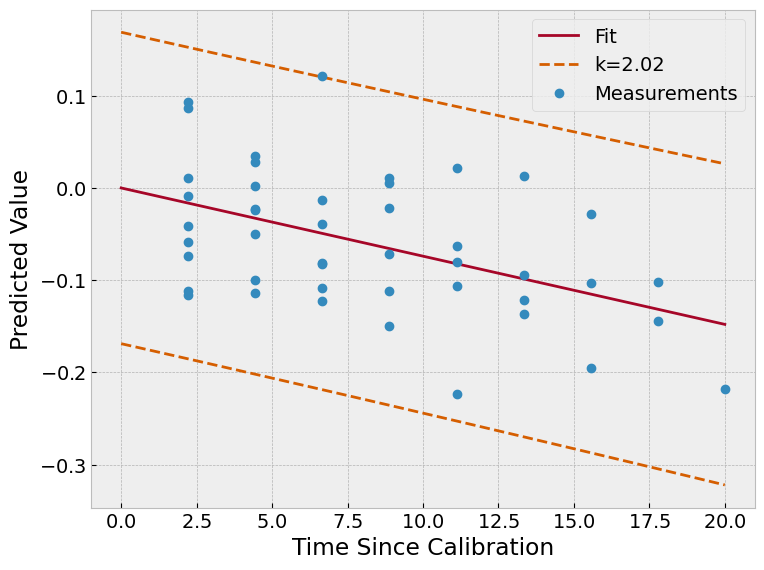

In [8]:
v.out.fit.plot();  # Plot just the fit

## Data as $\Delta$t, $\Delta$y values

If the data is already formatted in terms of time-since-last-calibration and deviation-from-prior calibration, use `VariablesInterval(dt, dy)` to initialize the calculator.

This example approximates uses the data in Table 7-2 of NASA Handbook. Compare with results in Table 7-4 and 7-7.

In [9]:
dt = np.array([70, 86, 104, 135, 167, 173])
deltas = np.array([.1, .11, .251, .299, .403, .615])
intv = VariablesInterval(dt, deltas, u0=.28, m=2, y0=10.03, utarget=.5, rlimits=(9, 11), rconf=.9)
intv.calculate()

Method              | Interval  
-------------------|----------
Uncertainty Target  | 327.15    
Reliability Target  | 140.09    


![IMG0][]

![IMG1][]



[IMG0]: 
[IMG1]: 

One-sided tolerances can be given by setting the other limit to None. Compare with results in NASA Table 7-5 and 7-6.

In [10]:
intv = VariablesInterval(dt, deltas, u0=.28, m=2, y0=10.03, utarget=.5, rlimits=(None, 11), rconf=.9)
intv.calcunc = False  # Suppress the Uncertainty Target method
intv.calculate()

Method              | Interval  
-------------------|----------
Reliability Target  | 171.75    


![IMG0][]



[IMG0]: 

In [11]:
# Not sure this is a good example by NASA.. initial uncertainty is below the target! But that's
# their example. NASA's table 7-2 shows the interval as 153, the point where the k=1.53 line
# crosses the lower limit.
intv = VariablesInterval(dt, deltas, u0=.28, m=2, y0=9.03, rlimits=(9, None), rconf=0.9)
intv.calcunc = False
intv.calculate()

Method              | Interval  
-------------------|----------
Reliability Target  | N/A       


![IMG0][]



[IMG0]: 

Castrup's Paper has data in Table 1, but it does not match the later figures and screenshots.

In [12]:
# Test with data from Castrup Table 1
dates = [parser.parse('29-Mar-03'),
         parser.parse('11-Jul-03'),
         parser.parse('31-Dec-03'),
         parser.parse('15-May-04'),
         parser.parse('29-Oct-04'),
         parser.parse('23-Jan-05'),
         parser.parse('03-Apr-05')
        ]

asfound = np.array([5.173, 5.123, 4.633, 4.915, 5.086, 4.913, 5.108])
asleft = np.array([5.073, 5.048, 4.993, 5.126, 5.024, 5.208, 5.451])
uncert = np.array([.2700, .2825, .2771, .2700, .2825, .2771, .2759])
datesord = np.array([d.toordinal() for d in dates])  # Ordinal day

v = VariablesIntervalAssets(u0=.25, y0=0, utarget=.4, rlimits=(-.810, .595), rconf=.80)
v.updateasset('asset1', enddates=datesord, asfound=asfound, asleft=asleft)
v.calculate()

Method              | Interval  
-------------------|----------
Uncertainty Target  | 608.15    
Reliability Target  | 327.46    


![IMG0][]

![IMG1][]



[IMG0]: 
[IMG1]: 

In [13]:
# Castrup Figure says fit line should intersect -.810 at 769.3 days.  It doesn't.
v.out.fit.predict_deviation(769.3, conf=.95)

(-0.7770606249874283, 1.1670542350550765)